# 0. Intro/meta/ReadMe

## 0.1 Other Notebooks

This summary notebook aims to dispaly the main results. Most of the heavy computation and in-depth analysis is in other notebooks.

The dataframes `posts` and `users` are created by the `data.wiki` module from the raw corpus if no `.pickle` file exists, but other notebooks add colums to those dataframes and some of those are necessary for this notebook to run. 

Here's what the other notebooks do.

- **WHAM subgroups** -- prepares data for running the WHAM model and compiles and runs the model (recommeneded to run this part in a script outside Jupyter, though)
- **Surprisal-based Alignment** -- analysis of the surprisal-based alignment metric that we ultimately abandoned 
- **Normalizing centrality** -- computes log-normalized centrality scores for the user network and adds `centrality` to the `user` dataframe.
- **(W)SCP Alignment** -- replication of the _Echoes of Power_ result; defines word-based SCP; investigates inverted effects for certain indicator categories for WSCP

In [10]:
from data import wiki
from data import corpus
import alignment

import nltk
import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from tqdm import tqdm_notebook as tqdm

tqdm().pandas()

markers = alignment.load_markers()
markers_list = list(markers)

posts = wiki.load_posts(recreate=False)
posts = corpus.tokenize_posts(posts, lower_case=True, overwrite=False)
posts = corpus.detect_markers(posts, markers, overwrite=False)

pairs = corpus.get_reply_pairs(posts)
users = wiki.load_users(posts=posts)

/home/xnobwi/LASN/lasn/data/corpus.py:18: UserWarning: Posts are already tokenized. Skipping tokenization.
  warnings.warn("Posts are already tokenized. Skipping tokenization.")
/home/xnobwi/LASN/lasn/data/corpus.py:64: UserWarning: All marker columns already exist. Skipping marker detection.
  warnings.warn("All marker columns already exist. Skipping marker detection.")


# 1. Descriptive statistics

In [11]:
print("{} users total".format(len(users)))
if not 'centrality' in users:
    print("Run Normalizing Centrality.ipynb first.")
threshold = users.centrality.mean() + users.centrality.std() # compute highly central threshold
users['highly_central'] = (users['centrality'] > threshold)
print("{} highly-central users (centrality > {:0.2f})".format(users.highly_central.sum(), threshold))
print("{} users with admin status".format(users.admin.sum()))
print("{} total posts".format(len(posts)))

30900 users total
1893 highly-central users (centrality > 0.83)
1812 users with admin status
376923 total posts


## 1.1 Centrality and adminship

User counts by normalized centrality (blue for admins).


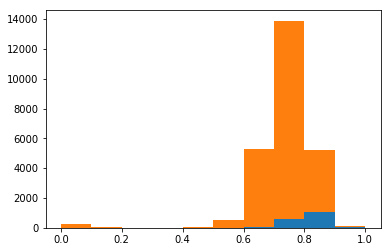

In [12]:
%matplotlib inline
from matplotlib import pyplot as plt
x1 = [user.centrality for i, user in users[users.admin].iterrows() if not np.isnan(user.centrality)]
x2 = [user.centrality for i, user in users[~users.admin].iterrows() if not np.isnan(user.centrality)]
plt.figure()
plt.hist([x1,x2], stacked=True)
print("User counts by normalized centrality (blue for admins).")

Centrality by post count (blue points are admins).


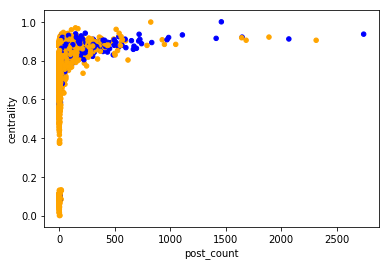

In [13]:
cs = ['blue' if user.admin else 'orange' for i,user in users.iterrows()]
users.plot.scatter('post_count', 'centrality', c=cs)
print("Centrality by post count (blue points are admins).")

## 1.2 Linguistic style markers

Per-user marker baselines.


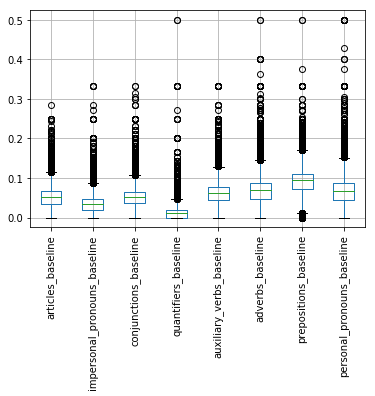

In [14]:
print("Per-user marker baselines.")
posts['len_tokens'] = posts['tokens'].apply(len)
pairs['len_tokens_b'] = pairs['tokens_b'].apply(len)

user_marker_totals = posts.groupby('user')[['len_tokens'] + list(markers)].sum()
for m in markers:
    users[m + '_baseline'] = user_marker_totals[m] / user_marker_totals['len_tokens']
    pairs = pairs.merge(users[[m+'_baseline']], left_on='user_b', right_index=True)

fig = users.boxplot(column=[m+'_baseline' for m in markers_list], rot=90)

# 2. SCP Coordination Results

## 2.1 Echoes of Power replication

We replicate the result that higher-power groups recieve more coordination than low-power groups (for both the adminship and highly-central conditions).

In [15]:
df = posts.merge(users, left_on='user', right_index=True)
df = df.merge(df, left_index=True, right_on='reply_to', suffixes=('_a', '_b'))

admin_scp = alignment.scp(df, 'admin')
central_scp = alignment.scp(df, 'highly_central')

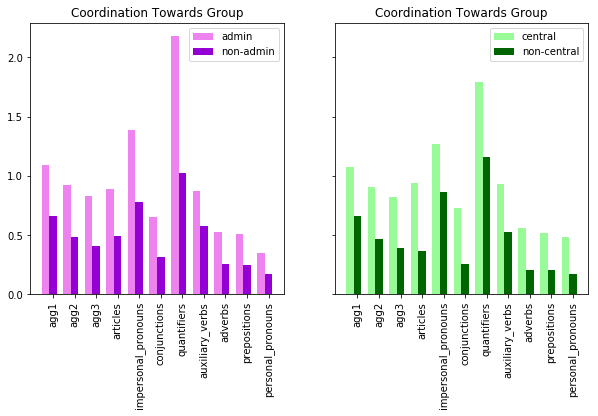

In [16]:
data = (admin_scp, central_scp)
labels = (['admin', 'non-admin'], ['central', 'non-central'])
colors = (['violet', 'darkviolet'], ['palegreen', 'darkgreen'])
groups = [True, False]
title = 'Coordination Towards Group'
items = ['agg1', 'agg2', 'agg3'] + markers_list

fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(10,5))
ind = np.arange(len(items))
width = 0.35

for ax, d, l, c in zip(axs, data, labels, colors):
    p = []
    for i, group in enumerate(groups):
        values = [d.mean(level=0).loc[group].loc[m] * 100 for m in items]
        p.append(ax.bar(ind+i*width, list(values), width=width, color=c[i]))
    ax.legend((p[i][0] for i in range(len(p))), l)
    ax.set_title(title)
    ax.set_xticklabels(items)
    ax.set_xticks(ind+width)
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)

## 2.2 Coordination in sub-communities

In [17]:
import networkx as nx

In [19]:
from data.network import create_network
network = create_network(pairs)

ImportError: No module named 'igraph'

In [21]:
network = wiki.load_network()

In [22]:
type(network)

NoneType